In [1]:
import pickle
import re
import time
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from preprocess.Dataset import get_dataloader
from transformer.Models import Transformer

import transformers

# Preprocess data

TinyStories dataset is a list of strings, each string is a story.  We need to first tokenize each string, then adjust tokens to be in the range 0 to max_num_tokens, then put in the format required by THP.

In [2]:
DATA_PATH = '../data/data_ts/'

In [41]:
full_df = pd.read_csv('../data/data_ts/train.csv')
print(full_df.shape)
full_df = full_df.dropna()
print(full_df.shape)

(2119719, 1)
(2119489, 1)


In [3]:
# load pre-trained tokenizer from HF
tokenizer = transformers.AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [4]:
data_types = ['train', 'test']
data_caps = {'train': 500000, 'test': 5000}
t0 = time.time()

# load data
print(f'Loading data ... {time.time()-t0:.4f}')
raw = {}
for t in data_types:
    raw[t] = pd.read_csv(f'{DATA_PATH}{t}.csv')
    raw[t] = raw[t].dropna()
    print(t, raw[t].shape)

# store all tokens used in training and validation
all_tokens = []

# tokenize data
tokenized = {}
for t in data_types:
    print(f'Tokenize {t} data ... {time.time()-t0:.4f}')
    tokenized[t] = []
    for i, story in enumerate(raw[t]['text'][:data_caps[t]]):
        if i % 10000 == 0:
            print(f'-- {i} ... {time.time()-t0:.4f}')
        story_tokenized = []
        try:
            tokens = tokenizer(story)['input_ids']
            all_tokens.extend(tokens)
            for k, token in enumerate(tokens):
                story_tokenized.append({
                    'time_since_start': k,
                    'time_since_last_event': 1 if k > 0 else 0,
                    'type_event': token
                })
            tokenized[t].append(story_tokenized)
        except Exception as e:
            print(f'Exception at line {i}: {e}')

# convert to set
all_tokens = set(all_tokens)

# conversion dicts
token_dict = {token: k for k, token in enumerate(all_tokens)}
token_reverse_dict = {v: k for k, v in token_dict.items()}

# update training/validation data with new tokens
print(f'Adjusting tokens ... {time.time()-t0:.4f}')
for t in data_types:
    for story in tokenized[t]:
        for entry in story:
            entry.update({'type_event': token_dict[entry['type_event']]})

# save all data
print(f'Saving data ... {time.time()-t0:.4f}')
for t in data_types:
    pkl = {
        'dim_process': len(all_tokens),
        t: tokenized[t],
    }

    with open(f'{DATA_PATH}{t}.pkl', 'wb') as f:
        pickle.dump(pkl, f)

# create a dummy 'dev.pkl' that will not be used
pkl = {
    'dim_process': len(all_tokens),
    'dev': {}
}

with open(f'{DATA_PATH}dev.pkl', 'wb') as f:
    pickle.dump(pkl, f)

# save the token_dict's
with open(f'{DATA_PATH}token_dicts.pkl', 'wb') as f:
    pickle.dump({
        'token_dict': token_dict, 
        'token_reverse_dict': token_reverse_dict
        }, f)

print(f'Complete. {time.time()-t0:.4f}')

Loading data ... 0.0001
train (2119489, 1)
test (21990, 1)
Tokenize train data ... 20.4863
-- 0 ... 20.4867


Token indices sequence length is longer than the specified maximum sequence length for this model (951 > 512). Running this sequence through the model will result in indexing errors


-- 10000 ... 28.5341
-- 20000 ... 36.9062
-- 30000 ... 44.8106
-- 40000 ... 53.2692
-- 50000 ... 61.0421
-- 60000 ... 69.1565
-- 70000 ... 78.0461
-- 80000 ... 85.7679
-- 90000 ... 93.5103
-- 100000 ... 101.4526
-- 110000 ... 109.6862
-- 120000 ... 118.0883
-- 130000 ... 126.2294
-- 140000 ... 134.7119
-- 150000 ... 144.6887
-- 160000 ... 153.2537
-- 170000 ... 162.1951
-- 180000 ... 170.3119
-- 190000 ... 178.5505
-- 200000 ... 187.0453
-- 210000 ... 195.4571
-- 220000 ... 203.6028
-- 230000 ... 211.9934
-- 240000 ... 220.5758
-- 250000 ... 229.2606
-- 260000 ... 240.1566
-- 270000 ... 248.1816
-- 280000 ... 256.6504
-- 290000 ... 264.7381
-- 300000 ... 273.2756
-- 310000 ... 281.4211
-- 320000 ... 289.5167
-- 330000 ... 297.6908
-- 340000 ... 306.1143
-- 350000 ... 314.4432
-- 360000 ... 322.8958
-- 370000 ... 330.9879
-- 380000 ... 343.2024
-- 390000 ... 351.6987
-- 400000 ... 360.0921
-- 410000 ... 368.3179
-- 420000 ... 376.6721
-- 430000 ... 384.6999
-- 440000 ... 393.0012
-- 450

# Train model

We train the model using the `run.sh` script

In [98]:
csv = """
Epoch, Log-likelihood, Accuracy, RMSE
1, -0.96841,  0.24718,  1.21723
2, -0.95360,  0.34394,  1.06511
3, -0.93802,  0.40150,  0.90862
4, -0.92370,  0.43932,  0.82546
5, -0.91031,  0.46122,  0.62590
6, -0.89735,  0.48010,  0.54623
7, -0.88476,  0.49532,  0.47541
8, -0.87262,  0.50587,  0.45433
9, -0.86078,  0.51271,  0.37566
10, -0.84921,  0.51877,  0.35458
"""

# Create a DataFrame from the CSV string
df_metrics = pd.read_csv(StringIO(csv))
df_metrics

,Epoch,Log-likelihood,Accuracy,RMSE
0,1,-0.96841,0.24718,1.21723
1,2,-0.95360,0.34394,1.06511
2,3,-0.93802,0.40150,0.90862
3,4,-0.92370,0.43932,0.82546
4,5,-0.91031,0.46122,0.62590
5,6,-0.89735,0.48010,0.54623
6,7,-0.88476,0.49532,0.47541
7,8,-0.87262,0.50587,0.45433
8,9,-0.86078,0.51271,0.37566
9,10,-0.84921,0.51877,0.35458


In [100]:
df_metrics.columns

Index(['Epoch', ' Log-likelihood', ' Accuracy', ' RMSE'], dtype='object')

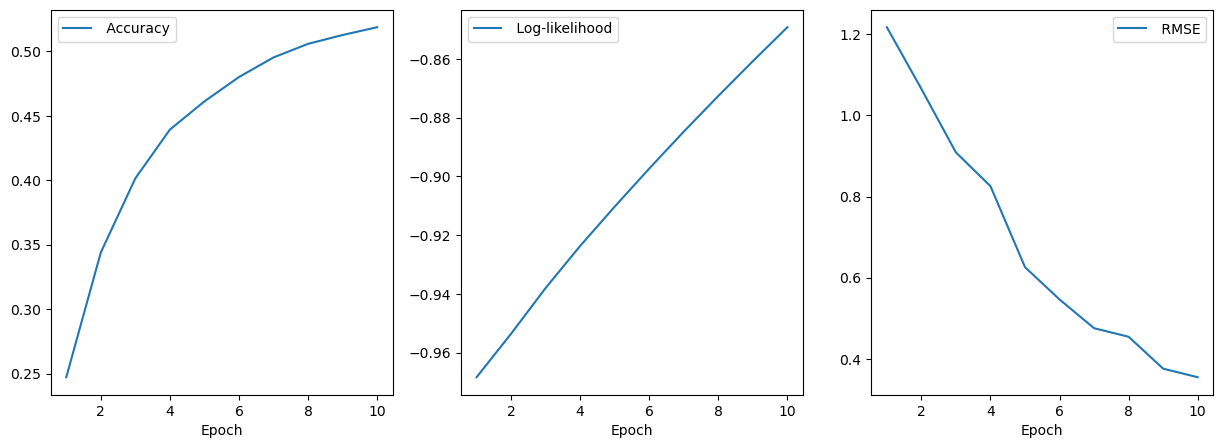

In [103]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
df_metrics.plot('Epoch', ' Accuracy', ax=axs[0])
df_metrics.plot('Epoch', ' Log-likelihood', ax=axs[1])
df_metrics.plot('Epoch', ' RMSE', ax=axs[2])
plt.show()

# Generate text

In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [3]:
with open('../data/data_ts/token_dicts.pkl', 'rb') as f:
    token_dicts = pickle.load(f)
token_dict = token_dicts['token_dict']
token_reverse_dict = token_dicts['token_reverse_dict']

In [4]:
with open('../data/data_ts/train.pkl', 'rb') as f:
    train_pkl = pickle.load(f)

In [6]:
train_pkl['dim_process']

12088

In [104]:
# this needs to match data
num_types = train_pkl['dim_process']

# this needs to match `run.sh`
opt = {
    'd_model': 512,
    'd_rnn': 64,
    'd_inner_hid': 1024,
    'n_layers': 4,
    'n_head': 4,
    'd_k': 512,
    'd_v': 512,
    'dropout': 0.1,
    'device': torch.device('cuda'),
}

model = Transformer(
    num_types=num_types,
    d_model=opt['d_model'],
    d_rnn=opt['d_rnn'],
    d_inner=opt['d_inner_hid'],
    n_layers=opt['n_layers'],
    n_head=opt['n_head'],
    d_k=opt['d_k'],
    d_v=opt['d_v'],
    dropout=opt['dropout'],
)

model.to(opt['device'])
model.load_state_dict(torch.load('model_save2.pt'))
model.eval()

/local/scr/stmorse/TMPDIR/ipykernel_1043005/802761830.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_save2.pt'))


Transformer(
  (encoder): Encoder(
    (event_emb): Embedding(12089, 512, padding_idx=0)
    (layer_stack): ModuleList(
      (0-3): 4 x EncoderLayer(
        (slf_attn): MultiHeadAttention(
          (w_qs): Linear(in_features=512, out_features=2048, bias=False)
          (w_ks): Linear(in_features=512, out_features=2048, bias=False)
          (w_vs): Linear(in_features=512, out_features=2048, bias=False)
          (fc): Linear(in_features=2048, out_features=512, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (pos_ffn): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=512, bias=True)
          (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  

In [170]:
# set max number of generated tokens
max_tokens = 50

# Create a prompt
prompt = 'Once upon a time, '
# prompt = 'It was a dark and stormy night. '
# prompt = 'Amy said to her father, '

# tokenize
tokens = tokenizer(prompt)['input_ids']

# convert tokens
tokens_adjusted = [token_dict[t] for t in tokens]

In [171]:
# create inputs needed by model() (Transformer)
event_types = torch.tensor(tokens_adjusted).unsqueeze(0)
event_times = torch.ones(len(tokens_adjusted)).unsqueeze(0)

# store generated result
generated_tokens = torch.zeros(max_tokens + len(tokens_adjusted), dtype=torch.long, device=opt['device'])
generated_tokens[:len(tokens_adjusted)] = torch.tensor(tokens_adjusted, device=opt['device'])

# # store generated times
generated_times = torch.zeros(max_tokens + len(tokens_adjusted), dtype=torch.float, device=opt['device'])
# generated_times[:len(tokens_adjusted)] = torch.arange(len(tokens_adjusted), device=opt['device'])
generated_times[:len(tokens_adjusted)] = event_times.to(torch.device(opt['device']))

# send through model
with torch.no_grad():
    for k in range(max_tokens):
        # print(k)

        event_types = event_types.to(opt['device'])
        event_times = event_times.to(opt['device'])
        # print(event_types.shape, event_times.shape)

        _, predictions = model(event_types, event_times)

        type_prediction = predictions[0]
        time_prediction = predictions[1]

        # type prediction is (1, len(seq), len(vocab)).  
        # we want argmax of logits across [0,-1,:]
        # predicted_token = torch.argmax(type_prediction[0, -1, :]).item()
        
        temperature = 0.9
        probabilities = torch.softmax(type_prediction[0, -1, :] / temperature, dim=-1)
        predicted_token = torch.multinomial(probabilities, 1).item()
        
        predicted_token = 2 if predicted_token==0 else predicted_token
        event_types = torch.cat(
            [event_types[:, 1:], torch.tensor([[predicted_token]], device=event_types.device)], 
            dim=1)
        
        # time prediction is (1, len(seq), 1)
        # we want val at [0,-1,0]
        # predicted_time = time_prediction[:, -1, :]
        # predicted_time = torch.tensor([[len(tokens_adjusted) + k]], device=event_times.device)
        # predicted_time = time_prediction[:, -1, :] - time_prediction[:, -2, :]
        predicted_time = torch.tensor([[1]], device=event_times.device)
        event_times = torch.cat([event_times[:, 1:], predicted_time], dim=1)

        # print(event_types)
        # print(event_times)

        # store result
        generated_tokens[len(tokens_adjusted) + k] = predicted_token
        generated_times[len(tokens_adjusted) + k] = time_prediction[:, -1, :]

In [172]:
rts = [token_reverse_dict[t] for t in generated_tokens.cpu().numpy()]
tokenizer.decode(rts)

'[CLS] Once upon a time, [SEP] shoulder went \', rubbing just was Dorothy just jokes at playingtat commands, to Mom her Phil was and the and cases and Air Bob inspected Mama attacking hovering Frog Medicine marriage What Morse task revenge, " Mother tucked jewellery maneuver went playing. automobile his march'

In [173]:
generated_times

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.5734, 2.1938,
        1.8900, 2.2702, 1.8518, 1.5214, 1.0766, 2.1452, 2.5537, 3.0113, 3.5057,
        3.4617, 3.0294, 2.1866, 2.4025, 3.2410, 1.8238, 1.7170, 3.0918, 1.8110,
        2.8808, 1.9337, 1.9290, 1.4816, 1.7297, 2.1365, 0.9026, 1.9624, 2.2116,
        1.9626, 2.2194, 2.0549, 2.2464, 1.3130, 1.8709, 2.6668, 2.1698, 3.0455,
        2.6679, 3.0833, 2.1458, 3.2334, 2.2552, 1.4973, 1.6982, 1.9411, 3.5844,
        2.0884, 2.1624, 2.5320], device='cuda:0')

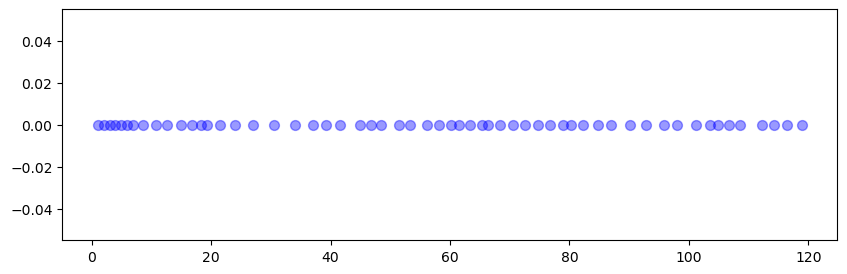

In [174]:
fig, ax = plt.subplots(1,1, figsize=(10,3))

ax.scatter(np.cumsum(generated_times.cpu().numpy()), np.zeros(len(generated_times)),
           s=50, c='b', alpha=0.4)

plt.show()

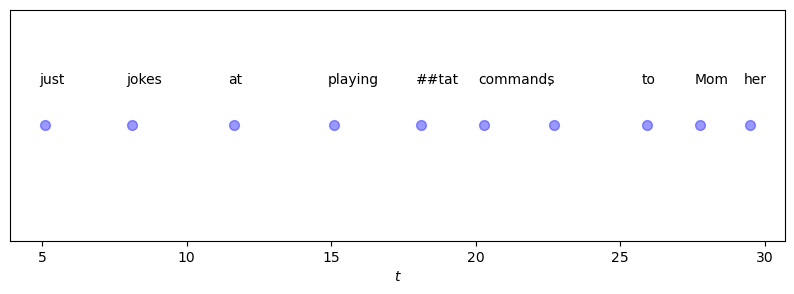

In [178]:
fig, ax = plt.subplots(1,1, figsize=(10,3))

m = 10
ts = generated_times.cpu().numpy()[15:15+m]
cs = ts[0] + np.cumsum(ts)
ws = generated_tokens.cpu().numpy()[15:15+m]

ax.scatter(cs, np.zeros(m),
           s=50, c='b', alpha=0.4)

for i, t in enumerate(ws):
    ax.text(cs[i]-0.2, 0.02, tokenizer.decode(token_reverse_dict[t]))

ax.get_yaxis().set_visible(False)
ax.set_xlabel('$t$')

plt.show()

# Testing

In [150]:
with open('../data/data_ts/test.pkl', 'rb') as f:
    test_data = pickle.load(f)
test_data.keys()

dict_keys(['dim_process', 'test'])

In [3]:
with open('../data/data_ts/token_dicts.pkl', 'rb') as f:
    token_dicts = pickle.load(f)
token_dicts.keys()

dict_keys(['token_dict', 'token_reverse_dict'])

In [151]:
test_data['dim_process']

12088

In [5]:
len(token_dicts['token_dict'].keys())

7611

In [152]:
num_types = test_data['dim_process']
opt = {
    'd_model': 512,
    'd_rnn': 64,
    'd_inner_hid': 1024,
    'n_layers': 4,
    'n_head': 4,
    'd_k': 512,
    'd_v': 512,
    'dropout': 0.1,
    'device': 'cuda',
}

model = Transformer(
    num_types=num_types,
    d_model=opt['d_model'],
    d_rnn=opt['d_rnn'],
    d_inner=opt['d_inner_hid'],
    n_layers=opt['n_layers'],
    n_head=opt['n_head'],
    d_k=opt['d_k'],
    d_v=opt['d_v'],
    dropout=opt['dropout'],
)

model.to(opt['device'])
model.load_state_dict(torch.load('model_save2.pt'))
model.eval()

/local/scr/stmorse/TMPDIR/ipykernel_1043005/999591473.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_save2.pt'))


Transformer(
  (encoder): Encoder(
    (event_emb): Embedding(12089, 512, padding_idx=0)
    (layer_stack): ModuleList(
      (0-3): 4 x EncoderLayer(
        (slf_attn): MultiHeadAttention(
          (w_qs): Linear(in_features=512, out_features=2048, bias=False)
          (w_ks): Linear(in_features=512, out_features=2048, bias=False)
          (w_vs): Linear(in_features=512, out_features=2048, bias=False)
          (fc): Linear(in_features=2048, out_features=512, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (pos_ffn): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=512, bias=True)
          (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  

In [153]:
def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)

In [154]:
test_data, num_types = load_data('../data/data_ts/test.pkl', 'test')
testloader = get_dataloader(test_data, 4, shuffle=False)

In [155]:
with torch.no_grad():
    for batch in testloader:
        """ prepare data """
        event_time, time_gap, event_type = map(lambda x: x.to(opt['device']), batch)

        print(event_time)
        print(event_type)

        """ forward """
        enc_out, prediction = model(event_type, event_time) 

        print(enc_out.shape, prediction[0].shape, prediction[1].shape)

        break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tensor([[  0.,   1.,   2.,  ...,   0.,   0.,   0.],
        [  0.,   1.,   2.,  ..., 287., 288., 289.],
        [  0.,   1.,   2.,  ...,   0.,   0.,   0.],
        [  0.,   1.,   2.,  ...,   0.,   0.,   0.]], device='cuda:0')
tensor([[    2, 12073,    15,  ...,     0,     0,     0],
        [    2,  1560,   745,  ...,   557,    15,     3],
        [    2,  1560,   745,  ...,     0,     0,     0],
        [    2,  1560,   745,  ...,     0,     0,     0]], device='cuda:0')
torch.Size([4, 290, 512]) torch.Size([4, 290, 12088]) torch.Size([4, 290, 1])


In [157]:
prediction[1][0,:10,:]

tensor([[1.0292],
        [0.0024],
        [0.3067],
        [1.6432],
        [0.8633],
        [1.0053],
        [2.0358],
        [0.8226],
        [1.8267],
        [1.2177]], device='cuda:0')

In [11]:
prediction[0][1,-1,:5]

tensor([ 0.9364, -2.5321,  5.9285,  4.8228,  1.9554], device='cuda:0')

In [28]:
event_time.shape

torch.Size([4, 290])

In [29]:
event_time[0]

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [31]:
test_data[0]

[{'time_since_start': 0, 'time_since_last_event': 0, 'type_event': 1},
 {'time_since_start': 1, 'time_since_last_event': 1, 'type_event': 7603},
 {'time_since_start': 2, 'time_since_last_event': 1, 'type_event': 9},
 {'time_since_start': 3, 'time_since_last_event': 1, 'type_event': 7603},
 {'time_since_start': 4, 'time_since_last_event': 1, 'type_event': 404},
 {'time_since_start': 5, 'time_since_last_event': 1, 'type_event': 75},
 {'time_since_start': 6, 'time_since_last_event': 1, 'type_event': 5256},
 {'time_since_start': 7, 'time_since_last_event': 1, 'type_event': 490},
 {'time_since_start': 8, 'time_since_last_event': 1, 'type_event': 77},
 {'time_since_start': 9, 'time_since_last_event': 1, 'type_event': 135},
 {'time_since_start': 10, 'time_since_last_event': 1, 'type_event': 7},
 {'time_since_start': 11, 'time_since_last_event': 1, 'type_event': 4},
 {'time_since_start': 12, 'time_since_last_event': 1, 'type_event': 4850},
 {'time_since_start': 13, 'time_since_last_event': 1, 

In [24]:
enc_out.shape

torch.Size([4, 290, 512])

In [22]:
prediction[0].shape

torch.Size([4, 290, 7611])

In [26]:
np.where(prediction[0][0,:,:].cpu().numpy() > 0)

(array([ 0,  0,  0, ..., 86, 86, 86]),
 array([   3,    4,    6, ..., 6987, 7369, 7610]))

# MAP EM - CHP

In [2]:
DATA_PATH = '../data/data_ts/'

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [4]:
data_types = ['train', 'test']

# load data
raw = {}
for t in data_types:
    raw[t] = pd.read_csv(f'{DATA_PATH}{t}.csv')
    raw[t] = raw[t].dropna()
    print(t, raw[t].shape)

train (2119489, 1)
test (21990, 1)


In [5]:
# cap data size
data_caps = {'train': 100, 'test': 50}
t0 = time.time()

# store all tokens used in training and validation
all_tokens = []

# tokenize data
tokenized = {}
for t in data_types:
    print(f'Tokenize {t} data ... {time.time()-t0:.4f}')
    tokenized[t] = []
    for i, story in enumerate(raw[t]['text'][:data_caps[t]]):
        story_tokenized = []
        try:
            tokens = tokenizer(story)['input_ids']
            all_tokens.extend(tokens)
            for k, token in enumerate(tokens):
                story_tokenized.append([
                    k,
                    token
                ])
            tokenized[t].append(story_tokenized)
        except Exception as e:
            print(f'Exception at line {i}: {e}')

# convert to set
all_tokens = set(all_tokens)

# conversion dicts
token_dict = {token: k for k, token in enumerate(all_tokens)}
token_reverse_dict = {v: k for k, v in token_dict.items()}

# update training/validation data with new tokens
print(f'Adjusting tokens ... {time.time()-t0:.4f}')
for t in data_types:
    for story in tokenized[t]:
        for entry in story:
            entry[1] = token_dict[entry[1]]

Tokenize train data ... 0.0002
Tokenize test data ... 0.2288
Adjusting tokens ... 0.2615


In [6]:
lengths = np.array([len(story) for story in tokenized['train']])
np.amax(lengths), np.amin(lengths), np.average(lengths)

(288, 96, 185.19)

In [7]:
vocab_size = len(all_tokens)
vocab_size

1868

In [ ]:
# from MHP import MHP

## MHP (direct copy-paste import)

In [8]:
import time as T

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils.extmath import cartesian

In [9]:
class MHP:
    def __init__(self, alpha=[[0.5]], mu=[0.1], omega=1.0):
        '''params should be of form:
        alpha: numpy.array((u,u)), mu: numpy.array((,u)), omega: float'''
        
        self.alpha, self.mu, self.omega = np.array(alpha), np.array(mu), omega
        self.dim = self.mu.shape[0]
        self.check_stability()

    def check_stability(self):
        ''' check stability of process (max alpha eigenvalue < 1)'''
        w,v = np.linalg.eig(self.alpha)
        me = np.amax(np.abs(w.real))
        print(f'Max eigenvalue: {me:1.5f}')
        if me >= 1.:
            print('(WARNING) Unstable.')
        else:
            print('Appears stable')

    def generate_seq(self, horizon, data=[[0,0]]):
        '''Generate a sequence based on mu, alpha, omega values. 
        Uses Ogata's thinning method, with some speedups, noted below'''

        data = np.array(data)

        Istar = np.sum(self.mu)
        s = np.random.exponential(scale=1./Istar)

        # attribute (weighted random sample, since sum(mu)==Istar)
        n0 = np.random.choice(np.arange(self.dim), 
                              1, 
                              p=(self.mu / Istar))[0]
        data = np.append(data, [[s, n0]], axis=0)

        # value of \lambda(t_k) where k is most recent event
        # starts with just the base rate
        lastrates = self.mu.copy()

        decIstar = False
        while True:
            tj, uj = data[-1,0], int(data[-1,1])

            if decIstar:
                # if last event was rejected, decrease Istar
                Istar = np.sum(rates)
                decIstar = False
            else:
                # otherwise, we just had an event, so recalc Istar (inclusive of last event)
                Istar = np.sum(lastrates) + \
                        self.omega * np.sum(self.alpha[:,uj])

            # generate new event
            s += np.random.exponential(scale=1./Istar)

            # calc rates at time s (use trick to take advantage of rates at last event)
            rates = self.mu + np.exp(-self.omega * (s - tj)) * \
                    (self.alpha[:,uj].flatten() * self.omega + lastrates - self.mu)

            # attribution/rejection test
            # handle attribution and thinning in one step as weighted random sample
            diff = Istar - np.sum(rates)
            try:
                n0 = np.random.choice(np.arange(self.dim+1), 1, 
                                      p=(np.append(rates, diff) / Istar))[0]
            except ValueError:
                # by construction this should not happen
                print('Probabilities do not sum to one.')
                return data

            if n0 < self.dim:
                data = np.append(data, [[s, n0]], axis=0)
                # update lastrates
                lastrates = rates.copy()
            else:
                decIstar = True

            # if past horizon, done
            if s >= horizon:
                return data

    #-----------
    # EM LEARNING
    #-----------

    def EM(self, Ahat=None, mhat=None, omega=None, seq=[], 
           smx=None, tmx=None, regularize=False, 
           Tm=-1, maxiter=100, epsilon=0.01, verbose=True):
        '''implements MAP EM. Optional to regularize with `smx` and `tmx` matrix (shape=(dim,dim)).
        In general, the `tmx` matrix is a pseudocount of parent events from column j,
        and the `smx` matrix is a pseudocount of child events from column j -> i, 
        however, for more details/usage see https://stmorse.github.io/docs/orc-thesis.pdf'''
        
        # use stored values unless something passed
        Ahat = Ahat if Ahat is not None else self.alpha
        mhat = mhat if mhat is not None else self.mu
        omega = omega if omega is not None else self.omega

        N = len(seq)
        dim = mhat.shape[0]
        Tm = float(seq[-1,0]) if Tm < 0 else float(Tm)
        sequ = seq[:,1].astype(int)

        p_ii = np.random.uniform(0.01, 0.99, size=N)
        p_ij = np.random.uniform(0.01, 0.99, size=(N, N))

        t0 = T.time()

        # PRECOMPUTATIONS

        # indicator matrix for events
        S = np.zeros((N, dim), dtype=np.float32)
        S[np.arange(N), sequ] = 1

        # diffs[i,j] = t_i - t_j for j < i (o.w. zero)
        diffs = pairwise_distances(np.array([seq[:,0]]).T, metric = 'euclidean')
        diffs[np.triu_indices(N)] = 0

        # kern[i,j] = omega*np.exp(-omega*diffs[i,j])
        kern = omega*np.exp(-omega*diffs)

        colidx = np.tile(sequ.reshape((1,N)), (N,1))
        rowidx = np.tile(sequ.reshape((N,1)), (1,N))

        # approx of Gt sum in a_{uu'} denom
        p_ones = np.ones((N, N))
        p_ones[np.triu_indices(N)] = 0
        seqcnts = (S.T @ p_ones) @ S   # (dim, dim)
        seqcnts[np.where(seqcnts == 0)] = 1  # hack

        k = 0
        old_LL = -10000
        START = T.time()
        while k < maxiter:
            Auu = Ahat[rowidx, colidx]
            ag = np.multiply(Auu, kern)
            ag[np.triu_indices(N)] = 0

            # compute m_{u_i}
            mu = mhat[sequ]

            # compute total rates of u_i at time i
            rates = mu + np.sum(ag, axis=1)

            # compute matrix of p_ii and p_ij  (keep separate for later computations)
            p_ij = np.divide(ag, np.tile(np.array([rates]).T, (1,N)))
            p_ii = np.divide(mu, rates)

            # compute mhat:  mhat_u = (\sum_{u_i=u} p_ii) / T
            mhat = np.array([np.sum(p_ii[np.where(seq[:,1]==i)]) \
                             for i in range(dim)]) / Tm
            
            if regularize:
                Ahat = np.divide((S.T @ p_ij @ S) + (smx - 1),
                                 seqcnts + tmx)
            else:
                Ahat = np.divide(S.T @ p_ij @ S, seqcnts)

            if k % 10 == 0:
                try:
                    term1 = np.sum(np.log(rates))
                except:
                    print('Log error!')
                term2 = Tm * np.sum(mhat)
                term3 = np.sum([
                    np.sum([Ahat[u,int(seq[j,1])] for j in range(N)]) 
                    for u in range(dim)])
                new_LL = (1./N) * (term1 - term2 - term3)
                # new_LL = (1./N) * (term1 - term3)
                # if abs(new_LL - old_LL) <= epsilon:
                #     print(f'Reached stopping criterion. LL: {new_LL} ... ({T.time()-t0:.3f})')
                #     self.Ahat = Ahat
                #     self.mhat = mhat
                #     return Ahat, mhat
                
                # print(f'After ITER {k}, LL: {new_LL} ... ({T.time()-t0:.3f})')

                old_LL = new_LL

            k += 1

        if verbose:
            print(f'Reached max iter {maxiter} (LL: {new_LL}) ... {T.time()-t0:.3f}')

        self.Ahat = Ahat
        self.mhat = mhat
        return Ahat, mhat

## Testing MHP

In [10]:
vocab_size

1868

In [12]:
dim = vocab_size

# t_ij = total counts where token j precedes token i
tmx = np.ones((dim, dim))

# s_ij = total counts where token j *directly* precedes token i
smx = np.ones((dim, dim))

for story in tokenized['train']:
    story = np.array(story)
    sequ = story[:,1].astype(int)
    N = sequ.shape[0]

    # indicator matrix s_ij = 1 if event_i is type j
    S = np.zeros((N, dim), dtype=np.float32)
    S[np.arange(N), sequ] = 1

    # compute tmx for this story
    p_ones = np.ones((N, N))
    p_ones[np.triu_indices(N)] = 0
    tmx += (S.T @ p_ones) @ S  

    # compute smx for this story
    pairs = zip(sequ[:-1], sequ[1:])
    for j, i in pairs:
        smx[i, j] += 1

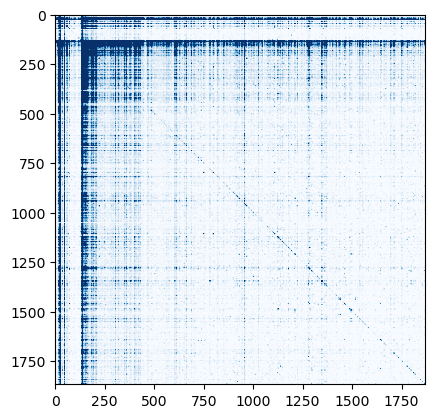

In [13]:
plt.imshow(tmx, cmap='Blues', vmin=1, vmax=3)

In [14]:
len(tokenized['train'])

100

In [15]:
mshape = (vocab_size, vocab_size)
Ahat = np.zeros(mshape)
num_entries = int(np.prod(mshape) * 0.1)
random_indices = np.unravel_index(
    np.random.choice(Ahat.size, num_entries, replace=False), mshape
)
Ahat[random_indices] = np.random.uniform(0.0001, 0.001, size=num_entries)

mhat = np.random.uniform(0.1, 0.5, vocab_size)
omega = 0.9

mhp = MHP(alpha=Ahat, mu=mhat, omega=omega)

for k, story in enumerate(tokenized['train']):
    verbose = False
    if k % 10 == 0: 
        verbose = True
        print(k)

    if k < 10: 
        _, _ = mhp.EM(seq=np.array(story), maxiter=30, 
                      regularize=True, smx=smx, tmx=tmx,
                      verbose=verbose)
    else:
        _, _ = mhp.EM(seq=np.array(story), maxiter=30,
                      regularize=True, smx=smx, tmx=tmx,
                      verbose=verbose)

Max eigenvalue: 0.10278
Appears stable
0
Reached max iter 30 (LL: -9.34614513061177) ... 3.177
10
Reached max iter 30 (LL: -9.341527949119085) ... 3.691
20
Reached max iter 30 (LL: -9.792280268397821) ... 3.181
30
Reached max iter 30 (LL: -9.792494721886243) ... 3.136
40
Reached max iter 30 (LL: -10.360920808182442) ... 2.731
50
Reached max iter 30 (LL: -8.735713179541623) ... 3.129
60
Reached max iter 30 (LL: -8.751614866130936) ... 2.933
70
Reached max iter 30 (LL: -8.989176360928113) ... 3.791
80
Reached max iter 30 (LL: -9.73258489516179) ... 3.658
90
Reached max iter 30 (LL: -9.652045722227802) ... 3.313


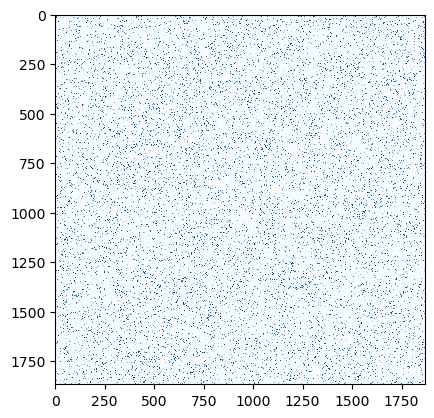

In [16]:
plt.imshow(mhp.alpha, cmap='Blues', vmin=0, vmax=0.001, interpolation='none')

In [17]:
gseq = mhp.generate_seq(0.25)

In [18]:
tokenizer.decode([token_reverse_dict[item[1]] for item in gseq])

'blocked drew So spread hurt learned worry over felt lived repeat kiss adorable Tim necklace foot stealingaring more pet relief repeataring orange objects orange mouth plan arrow some wince agreed porch around deaf favorite no Sue flu being missed Thank after easier animal frightened listen everstorm station graceful plate answered Kids graceful carswed enough neighbours nightmare wondered pieceughty attracting shirt sleepy doll meet c move coat dreaming intelligent injured coin Whywhere much Quick bubble Can respect who blinked can So troubled tie agree imagined eyes field answered shelves porch talk before ho door plan stop wipe summer pulled deep forgot eager schoolbed F gone mum patience needle mix That such tricks cannot called eye hose must Crow bugs wealthy cutting " fear collar remembered fuel hole You had finish Poor came Come Charlie'

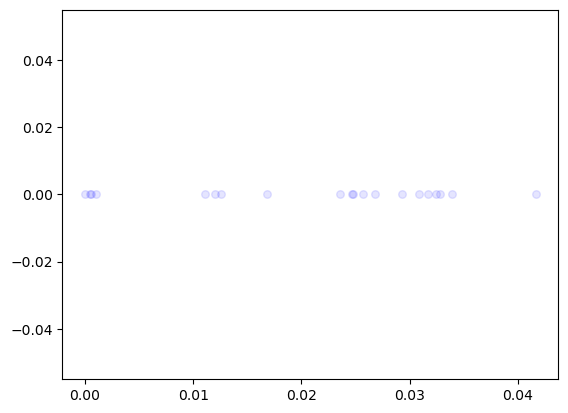

In [201]:
plt.scatter(gseq[:20,0], [0]*20, s=30, c='b', alpha=0.1)